In [93]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

test_data  = pd.read_csv('../test_data_preprocess.csv')

compt_weights = pd.read_csv('../computed_weights/compt_weights_CoxPH_mean_repeat.csv')
if 'Unnamed: 0' in compt_weights.columns:
    compt_weights.pop('Unnamed: 0')

(100, 16)

### Directly plotting montecarlo weights

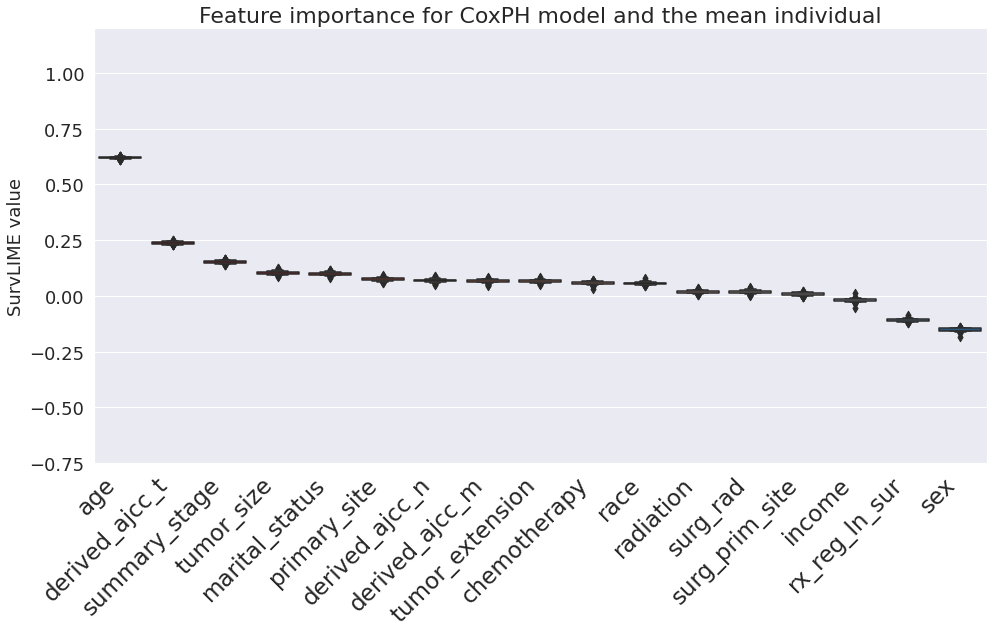

In [360]:
model_name = 'CoxPH'
data = pd.read_csv(f'../computed_weights/compt_weights_{model_name}_montecarlo.csv')
data = data.rename(columns={'sec_rec': 'sex_rec', 'rx_summ_scope_reg_ln_sur_rec': 'rx_reg_ln_sur_rec', 'prim_site_rec': 'surg_prim_site_rec'})
data.columns = data.columns.str[:-4]
#print(data.columns)
#data.drop('derived_ajcc_m_rec', inplace=True, axis=1)
sns.set()
median_up = {}
median_down = {}
threshold = 0
for (columnName, columnData) in data.items():
    median_value = np.median(columnData)
    if median_value > threshold:
        median_up[columnName] = median_value
    else:
        median_down[columnName] = median_value

median_up = dict(
    sorted(median_up.items(), key=lambda item: item[1], reverse=True)
)
median_down = dict(
    sorted(median_down.items(), key=lambda item: item[1], reverse=True)
)
pal_up = sns.color_palette("Reds_r", n_colors=len(median_up))
pal_down = sns.color_palette("Blues", n_colors=len(median_down))
colors_up = {key: val for key, val in zip(median_up.keys(), pal_up)}
colors_down = {key: val for key, val in zip(median_down.keys(), pal_down)}
custom_pal = {**colors_up, **colors_down}

data_reindex = data.reindex(columns=custom_pal.keys())
data_melt = pd.melt(data_reindex)
_, ax = plt.subplots(figsize=(16,8))

p = sns.boxenplot(
    x="variable",
    y="value",
    data=data_melt,
    palette=custom_pal,
    ax=ax,
)
# Set the size of the x-axis ticks
plt.xticks(fontsize=23, rotation=45, ha='right')
# remove x and y labels
ax.set_xlabel('')
ax.set_ylabel('SurvLIME value', fontsize=18)
ax.set_ylim([-0.75,1.2])
# Set the size of the x-axis ticks
plt.yticks(fontsize=18)

ax.set_title(f'Feature importance for {model_name} model and the mean individual', fontsize=22)

plt.savefig(save_path +f'{model_name}_survlime_values.png', bbox_inches='tight', dpi=300)

Text(0.5, 1.0, 'Mean patience feature importance for RSF')

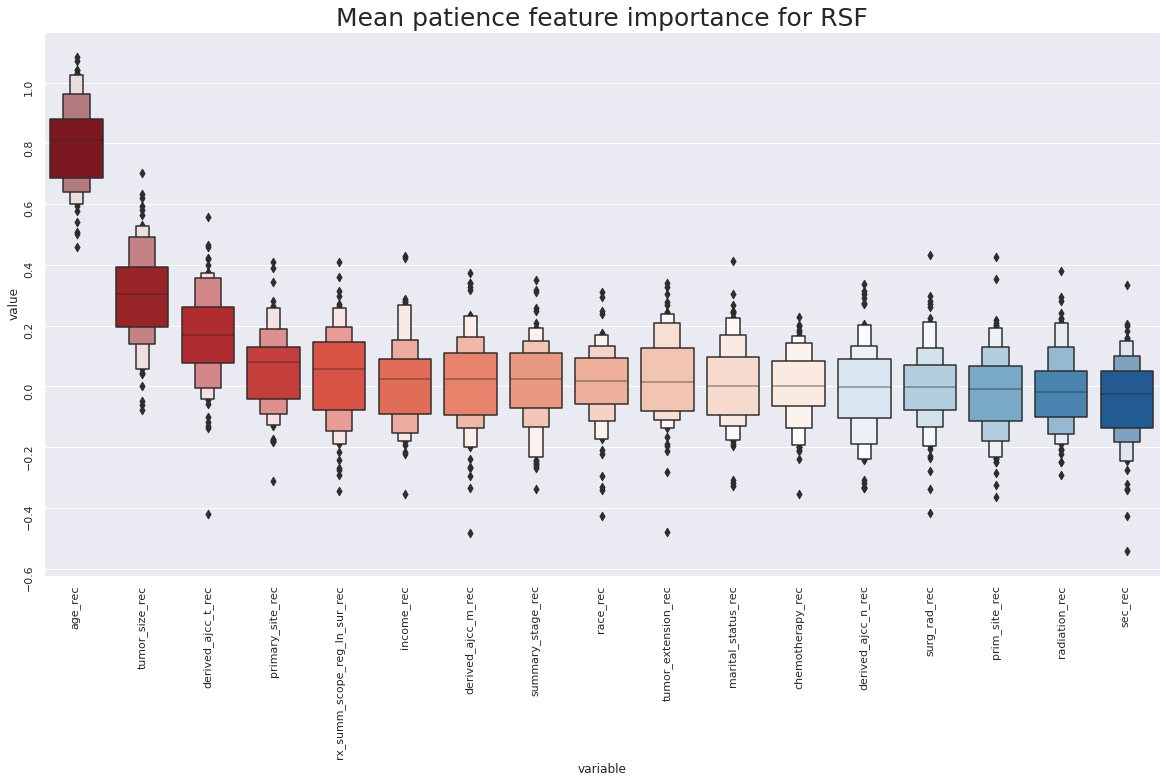

In [292]:
_, ax = plt.subplots(figsize=(20,10))
ax.tick_params(labelrotation=90)
p = sns.boxenplot(
    x="variable",
    y="value",
    data=data_melt,
    palette=custom_pal,
    ax=ax,
)
ax.set_title(f'Mean patience feature importance for {model_name}', fontsize=25)


Text(0.5, 1.0, 'Mean patient feature importance for RSF')

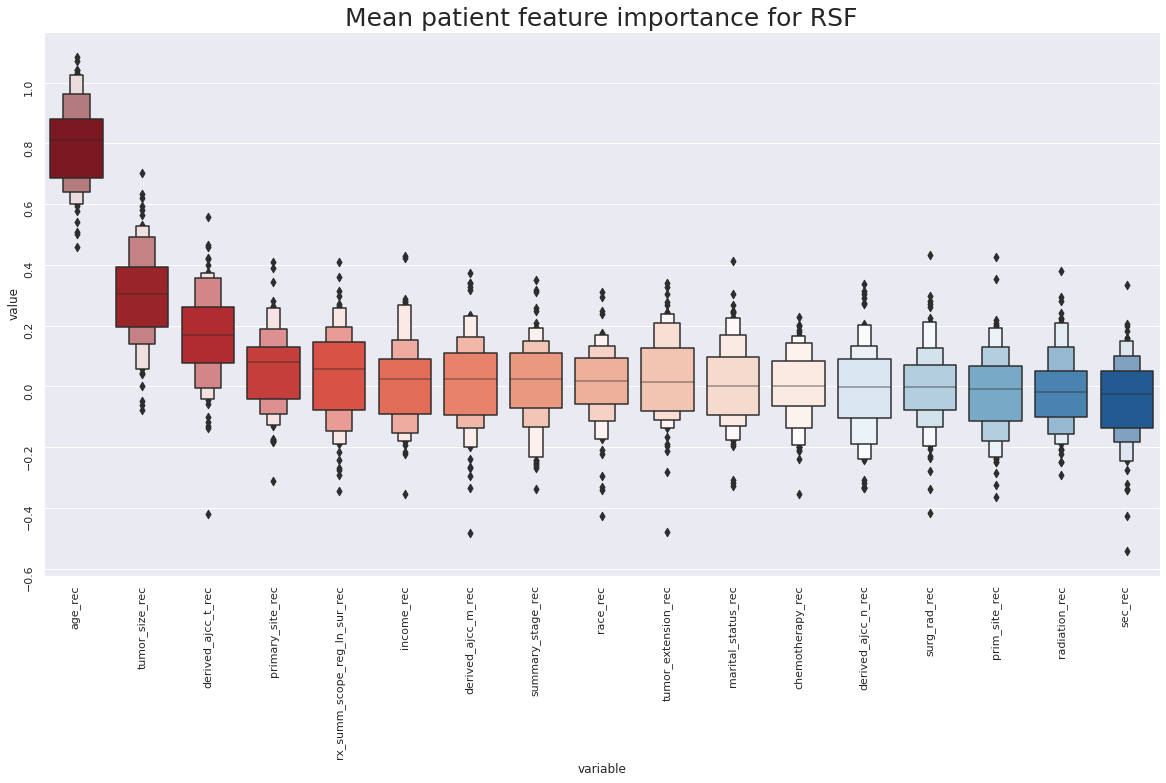

In [293]:
_, ax = plt.subplots(figsize=(20,10))
ax.tick_params(labelrotation=90)
p = sns.boxenplot(
    x="variable",
    y="value",
    data=data_melt,
    palette=custom_pal,
    ax=ax,
)
ax.set_title(f'Mean patient feature importance for {model_name}', fontsize=25)


### Plot comparison of SurvLIMEpy and CoxPH coefficients

In [313]:
# create dataframes
df_surv = pd.DataFrame({
    'age_rec': [0.619267],
    'derived_ajcc_t_rec': [0.236984],
    'summary_stage_rec': [0.153395],
    'tumor_size_rec': [0.103933],
    'marital_status_rec': [0.099895],
    'primary_site_rec': [0.074523],
    'derived_ajcc_n_rec': [0.069728],
    'derived_ajcc_m_rec': [0.067542],
    'tumor_extension_rec': [0.066578],
    'chemotherapy_rec': [0.058350],
    'race_rec': [0.057141],
    'radiation_rec': [0.019094],
    'surg_rad_rec': [0.019002],
    'surg_prim_site_rec': [0.008202],
    'income_rec': [-0.019519],
    'rx_reg_ln_sur_rec': [-0.108349],
    'sex_rec': [-0.151360]
})

df_cox = pd.DataFrame({
    'age_rec': [0.795],
    'tumor_size_rec': [0.134],
    'tumor_extension_rec': [0.0841],
    'surg_prim_site_rec': [0.0104],
    'sex_rec': [-0.195],
    'race_rec': [0.0735],
    'marital_status_rec': [0.129],
    'primary_site_rec': [0.0952],
    'derived_ajcc_t_rec': [0.303],
    'derived_ajcc_n_rec': [0.0896],
    'derived_ajcc_m_rec': [0.0873],
    'summary_stage_rec': [0.198],
    'radiation_rec': [0.0256],
    'chemotherapy_rec': [0.074],
    'rx_reg_ln_sur_rec': [-0.139],
    'surg_rad_rec': [0.0256],
    'income_rec': [-0.0249]
})

# sort the dataframes by values in df2 in increasing order
df_surv = df_surv.reindex(df_cox.abs().sort_values(list(df_cox), ascending=True).index)
df_cox = df_cox.reindex(columns=df_surv.columns)

df_surv.columns = df_surv.columns.str[:-4]
df_cox.columns = df_cox.columns.str[:-4]

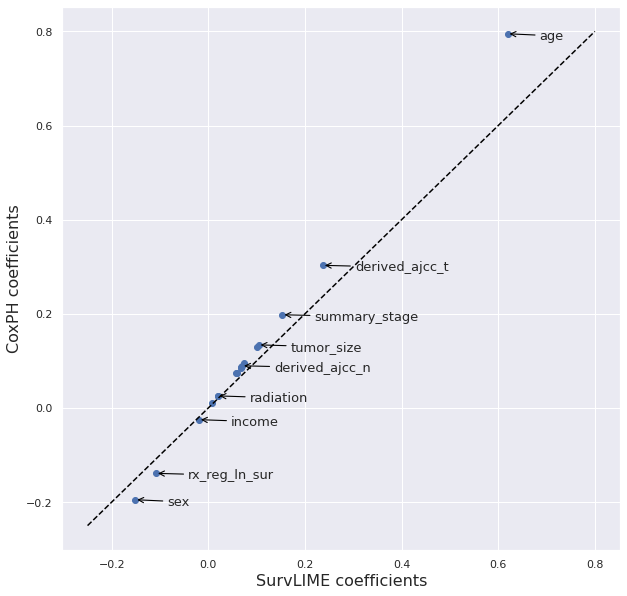

In [339]:
fig, ax = plt.subplots(figsize=(10, 10))

# Assign colors to the points based on their position along a color scale
cmap = plt.cm.get_cmap('RdBu')
colors = cmap(df_cox.values)[0][::-1]


# Create scatter plot with colors
ax.scatter(df_surv, df_cox)
# Add 45 degree angle
plt.plot([-0.25, 0.8], [-0.25, 0.8], linestyle='--', color='black')

# Label axes
plt.xlabel('SurvLIME coefficients', fontsize=16)
plt.ylabel('CoxPH coefficients', fontsize=16)



# Annotate each point with feature name
min_distance = 0.05  # adjust this value to set the minimum distance between annotations
prev_x, prev_y = None, None
for i, txt in enumerate(df_surv.columns):
    x = df_surv.iloc[:, i].values
    y = df_cox.iloc[:, i].values
    if prev_x is None or prev_y is None or ((x - prev_x) ** 2 + (y - prev_y) ** 2) ** 0.5 > min_distance:
        ax.annotate(txt, (x, y), xytext=(32, -2), textcoords='offset points', fontsize=13,
                    ha='left', va='center', arrowprops=dict(color='black', arrowstyle='->', linewidth=1.1))
        
        prev_x, prev_y = x, y

plt.savefig(save_path +'cox_surv_comparison.png', bbox_inches='tight', dpi=300)

plt.show()